# Ensemble and Boosting

In [67]:
%reset -f

In [68]:
from scipy                         import stats
from statsmodels.tsa.stattools     import acf
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.preprocessing         import StandardScaler
from sklearn.metrics               import mean_squared_error, mean_absolute_error
from sklearn.model_selection       import GridSearchCV, TimeSeriesSplit, cross_val_score, cross_validate

import csv
import xgboost           as xgb
import numpy             as np
import seaborn           as sns
import matplotlib.pyplot as plt
import pandas            as pd
import statsmodels.api   as sm

In [69]:
sns.set_style('darkgrid')
pd.plotting.register_matplotlib_converters()
sns.mpl.rc('figure',figsize=(16, 6))

In [70]:
f = pd.read_csv('pollution.csv')
df = pd.DataFrame(f)

In [71]:
df.columns

Index(['pm25', 'dewp', 'temp', 'cws', 'target', 'cbwd_1', 'cbwd_2', 'cbwd_3',
       'clunar', 'cstorm', 'cwkend', 'nord_cws', 'date', 'cmonth_2.0',
       'cmonth_3.0', 'cmonth_4.0', 'cmonth_5.0', 'cmonth_6.0', 'cmonth_7.0',
       'cmonth_8.0', 'cmonth_9.0', 'cmonth_10.0', 'cmonth_11.0', 'cmonth_12.0',
       'chour_1.0', 'chour_2.0', 'chour_3.0', 'chour_4.0', 'chour_5.0',
       'chour_6.0', 'chour_7.0', 'chour_8.0', 'chour_9.0', 'chour_10.0',
       'chour_11.0', 'chour_12.0', 'chour_13.0', 'chour_14.0', 'chour_15.0',
       'chour_16.0', 'chour_17.0', 'chour_18.0', 'chour_19.0', 'chour_20.0',
       'chour_21.0', 'chour_22.0', 'chour_23.0', 'pm25_1', 'pm25_2'],
      dtype='object')

In [72]:
df.describe()

,pm25,dewp,temp,cws,target,cbwd_1,cbwd_2,cbwd_3,clunar,cstorm,...,chour_16.0,chour_17.0,chour_18.0,chour_19.0,chour_20.0,chour_21.0,chour_22.0,chour_23.0,pm25_1,pm25_2
count,43795.000000,43795.000000,43795.000000,43795.000000,43795.000000,43795.000000,43795.000000,43795.000000,43795.000000,43795.000000,...,43795.000000,43795.000000,43795.000000,43795.000000,43795.000000,43795.000000,43795.000000,43795.000000,43795.000000,43795.000000
mean,98.022080,1.830323,12.460920,23.307569,98.019203,0.214271,0.322617,0.114077,0.000799,0.000046,...,0.041671,0.041671,0.041671,0.041671,0.041671,0.041671,0.041671,0.041671,98.026030,98.029433
std,90.523132,14.429070,12.192778,50.054601,90.523864,0.410320,0.467483,0.317908,0.028259,0.006758,...,0.199840,0.199840,0.199840,0.199840,0.199840,0.199840,0.199840,0.199840,90.522979,90.522470
min,0.000000,-40.000000,-19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,-10.000000,2.000000,1.000000,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,30.000000,30.000000
50%,74.000000,2.000000,14.000000,5.000000,74.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,74.000000,74.000000
75%,134.000000,15.000000,23.000000,21.000000,134.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,134.000000,134.000000
max,994.000000,28.000000,42.000000,585.000000,994.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,994.000000,994.000000


In [73]:
df.head(10)

,pm25,dewp,temp,cws,target,cbwd_1,cbwd_2,cbwd_3,clunar,cstorm,...,chour_16.0,chour_17.0,chour_18.0,chour_19.0,chour_20.0,chour_21.0,chour_22.0,chour_23.0,pm25_1,pm25_2
0,138,-7,-5,6,109,0,0,0,0,0,...,0,0,0,0,0,0,0,0,181,159
1,109,-7,-6,7,105,0,0,0,0,0,...,0,0,0,0,0,0,0,0,138,181
2,105,-7,-6,8,124,0,0,0,0,0,...,0,0,0,0,0,0,0,0,109,138
3,124,-7,-5,10,120,0,0,0,0,0,...,0,0,0,0,0,0,0,0,105,109
4,120,-8,-6,12,132,0,0,0,0,0,...,0,0,0,0,0,0,0,0,124,105
5,132,-7,-5,14,140,0,0,0,0,0,...,0,0,0,0,0,0,0,0,120,124
6,140,-7,-5,17,152,0,0,0,0,0,...,0,0,0,0,0,0,0,0,132,120
7,152,-8,-5,20,148,0,0,0,0,0,...,0,0,0,0,0,0,0,0,140,132
8,148,-8,-5,23,164,0,0,0,0,0,...,0,0,0,0,0,0,0,0,152,140
9,164,-8,-5,27,158,0,0,0,0,0,...,0,0,0,0,0,0,0,0,148,152


In [74]:
df['date'] = pd.to_datetime(df.date)

In [75]:
# Setting DateTime index
df['date'] = pd.to_datetime(df.date)
df.set_index('date', inplace=True)

In [76]:
df[['target', 'pm25']]

,target,pm25
date,,
2010-02-01 04:00:00,109,138
2010-02-01 05:00:00,105,109
2010-02-01 06:00:00,124,105
2010-02-01 07:00:00,120,124
2010-02-01 08:00:00,132,120
...,...,...
2014-12-31 18:00:00,8,10
2014-12-31 19:00:00,10,8
2014-12-31 20:00:00,10,10


In [77]:
# Check for any NaN or infinite values across rows
df[df.isin([np.nan, np.inf, -np.inf]).any(axis=1)].count().sum()

0

### A quick look at the data

<AxesSubplot:xlabel='date'>

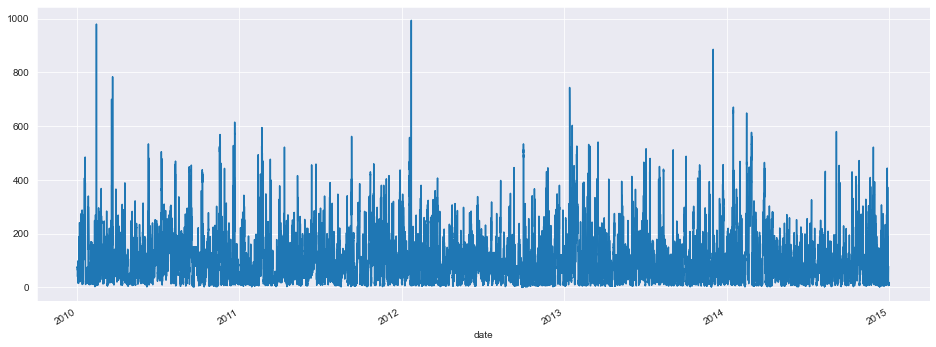

In [78]:
df['pm25'].plot()

# Subset data into 3 consectuive sections (Time Series CV)

### To run a two-step stacked time-series model, the temporal order of the data needs to be strictly followed. Hence, we can only split the data into three ordered batches.

### The first (earliest) batch we will call the base-training set and is a gridsearch hyper-parameter tuning of the base models.

### The optimised base model then makes an out-of-sample prediction on the next batch of data, which is used to train the meta model (Calling this data the meta-training set)

### The Meta fitted model then makes an out-of-sample prediction on the final batch of data, which is used for scoring the models performance (calling this data the test set)

In [79]:
# Extract the last 10% of observations as the test set
df_test  = df.iloc[-4380:]
df_train = df.iloc[:-4380]

In [80]:
y_test  = df_test.pop('target')
y_train = df_train.pop('target')

In [81]:
X_train = df_train
X_test  = df_test

### The remaining data before the test set is split 2/3 base-training and 1/3 meta-training sets

In [82]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4380 entries, 2014-02-07 11:00:00 to 2014-12-31 22:00:00
Data columns (total 47 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   pm25         4380 non-null   int64
 1   dewp         4380 non-null   int64
 2   temp         4380 non-null   int64
 3   cws          4380 non-null   int64
 4   cbwd_1       4380 non-null   int64
 5   cbwd_2       4380 non-null   int64
 6   cbwd_3       4380 non-null   int64
 7   clunar       4380 non-null   int64
 8   cstorm       4380 non-null   int64
 9   cwkend       4380 non-null   int64
 10  nord_cws     4380 non-null   int64
 11  cmonth_2.0   4380 non-null   int64
 12  cmonth_3.0   4380 non-null   int64
 13  cmonth_4.0   4380 non-null   int64
 14  cmonth_5.0   4380 non-null   int64
 15  cmonth_6.0   4380 non-null   int64
 16  cmonth_7.0   4380 non-null   int64
 17  cmonth_8.0   4380 non-null   int64
 18  cmonth_9.0   4380 non-null   int64
 19  cmonth_10.0 

In [83]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4380 entries, 2014-02-07 11:00:00 to 2014-12-31 22:00:00
Data columns (total 47 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   pm25         4380 non-null   int64
 1   dewp         4380 non-null   int64
 2   temp         4380 non-null   int64
 3   cws          4380 non-null   int64
 4   cbwd_1       4380 non-null   int64
 5   cbwd_2       4380 non-null   int64
 6   cbwd_3       4380 non-null   int64
 7   clunar       4380 non-null   int64
 8   cstorm       4380 non-null   int64
 9   cwkend       4380 non-null   int64
 10  nord_cws     4380 non-null   int64
 11  cmonth_2.0   4380 non-null   int64
 12  cmonth_3.0   4380 non-null   int64
 13  cmonth_4.0   4380 non-null   int64
 14  cmonth_5.0   4380 non-null   int64
 15  cmonth_6.0   4380 non-null   int64
 16  cmonth_7.0   4380 non-null   int64
 17  cmonth_8.0   4380 non-null   int64
 18  cmonth_9.0   4380 non-null   int64
 19  cmonth_10.0 

In [84]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 39415 entries, 2010-02-01 04:00:00 to 2014-02-07 10:00:00
Data columns (total 47 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   pm25         39415 non-null  int64
 1   dewp         39415 non-null  int64
 2   temp         39415 non-null  int64
 3   cws          39415 non-null  int64
 4   cbwd_1       39415 non-null  int64
 5   cbwd_2       39415 non-null  int64
 6   cbwd_3       39415 non-null  int64
 7   clunar       39415 non-null  int64
 8   cstorm       39415 non-null  int64
 9   cwkend       39415 non-null  int64
 10  nord_cws     39415 non-null  int64
 11  cmonth_2.0   39415 non-null  int64
 12  cmonth_3.0   39415 non-null  int64
 13  cmonth_4.0   39415 non-null  int64
 14  cmonth_5.0   39415 non-null  int64
 15  cmonth_6.0   39415 non-null  int64
 16  cmonth_7.0   39415 non-null  int64
 17  cmonth_8.0   39415 non-null  int64
 18  cmonth_9.0   39415 non-null  int64
 19  cmonth_10.0

In [85]:
X_train

,pm25,dewp,temp,cws,cbwd_1,cbwd_2,cbwd_3,clunar,cstorm,cwkend,...,chour_16.0,chour_17.0,chour_18.0,chour_19.0,chour_20.0,chour_21.0,chour_22.0,chour_23.0,pm25_1,pm25_2
date,,,,,,,,,,,,,,,,,,,,,
2010-02-01 04:00:00,138,-7,-5,6,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,181,159
2010-02-01 05:00:00,109,-7,-6,7,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,138,181
2010-02-01 06:00:00,105,-7,-6,8,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,109,138
2010-02-01 07:00:00,124,-7,-5,10,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,105,109
2010-02-01 08:00:00,120,-8,-6,12,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,124,105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-02-07 06:00:00,59,20,21,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,65,45
2014-02-07 07:00:00,58,20,21,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,59,65
2014-02-07 08:00:00,57,20,22,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,58,59


In [86]:
y_train

date
2010-02-01 04:00:00    109
2010-02-01 05:00:00    105
2010-02-01 06:00:00    124
2010-02-01 07:00:00    120
2010-02-01 08:00:00    132
                      ... 
2014-02-07 06:00:00     58
2014-02-07 07:00:00     57
2014-02-07 08:00:00     52
2014-02-07 09:00:00     33
2014-02-07 10:00:00     50
Name: target, Length: 39415, dtype: int64

### Gridsearch using time-series cross-validation

#### Scale each variable to mean 0 and standard deviation 1

In [87]:
scaler = StandardScaler()

In [88]:
# Fit-transform the first batch base-training set, and only transform the latter two batches
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)
X_test  = scaler.transform(df_test)

In [89]:
#Make an inner validation scheme for Gridsearch Cross-Validation
time_split_inner = TimeSeriesSplit(n_splits = 3) # These splits are used to find the best GS hyper-parameters

### GridsearchCV : XGBoost

In [90]:
xgb = xgb.XGBRegressor(n_estimators=100, gamma=200, eta=0.1, subsample=1, objective='reg:squarederror', random_state=0)

xgb_params = {'n_estimators': range(70, 140, 10),
              'subsample': [0.5, 0.75, 1],
              'eta': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4],
              'gamma': range(150, 200, 10)}

# gamma range changed from 150-310 to 150-200

In [91]:
#training
gs_xgb = GridSearchCV(xgb, xgb_params, cv=time_split_inner, scoring = 'neg_mean_squared_error', n_jobs=-1, verbose=1)

gs_xgb.fit(X_train, y_train)

Fitting 3 folds for each of 630 candidates, totalling 1890 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eta=0.1,
                                    eval_metric=None, gamma=200, gpu_id=None,
                                    grow_policy=None, importance_type...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=0,
 

### Check the optimal parameters for the Model

In [92]:
gs_xgb.best_params_

{'eta': 0.1, 'gamma': 180, 'n_estimators': 70, 'subsample': 0.75}

### save the test set forecast and test set actual values in the same df

In [93]:
df_pred = pd.DataFrame([])
df_pred['Target'] = y_test
df_pred['XGBoost'] = gs_xgb.predict(X_test)

### Plot the forecast and actuals on the test data

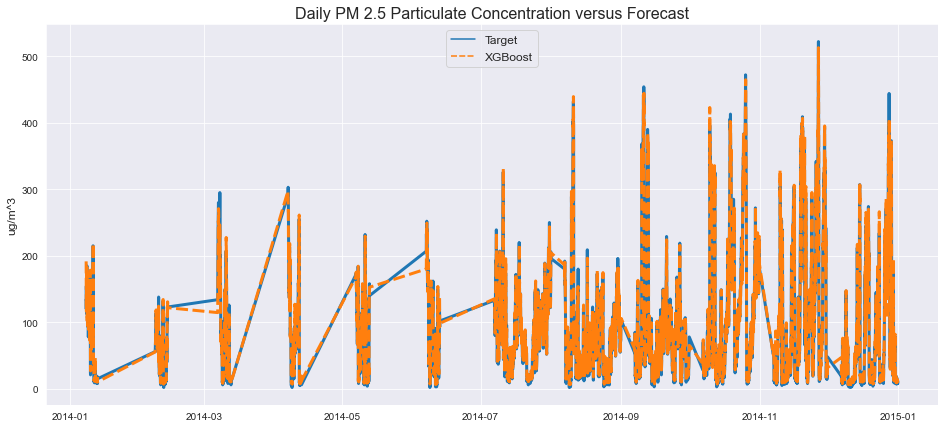

In [94]:
fig, ax = plt.subplots(figsize=(16,7))

sns.lineplot(data=df_pred[['Target', 'XGBoost']], ax=ax, linewidth=3)
plt.legend(loc='upper center', fontsize=12)
plt.title('Daily PM 2.5 Particulate Concentration versus Forecast', fontsize=16)
plt.xlabel('')
plt.ylabel('ug/m^3', fontsize=12);

### Model Predictions on first 400 observations in test data

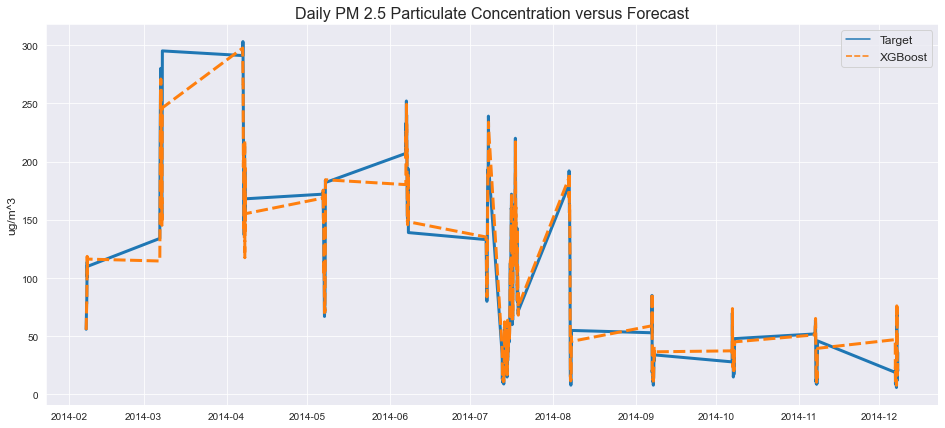

In [95]:
fig, ax = plt.subplots(figsize=(16,7))

sns.lineplot(data=df_pred[['Target', 'XGBoost']].iloc[:400], ax=ax, linewidth=3)
plt.legend(loc='upper right', fontsize=12)
plt.title('Daily PM 2.5 Particulate Concentration versus Forecast', fontsize=16)
plt.xlabel('')
plt.ylabel('ug/m^3', fontsize=12);

### Model Predictions on middle 400 observations in test data

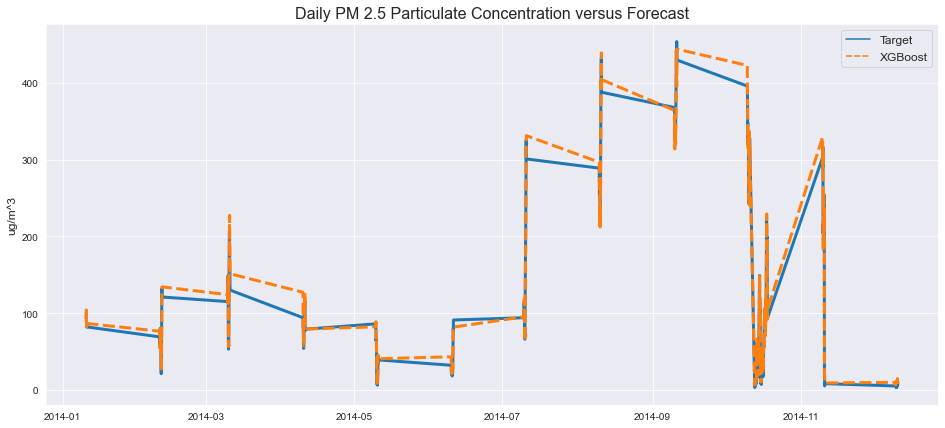

In [96]:
fig, ax = plt.subplots(figsize=(16,7))

sns.lineplot(data=df_pred[['Target', 'XGBoost']].iloc[2190:2590], ax=ax, linewidth=3)
plt.legend(loc='upper right', fontsize=12)
plt.title('Daily PM 2.5 Particulate Concentration versus Forecast', fontsize=16)
plt.xlabel('')
plt.ylabel('ug/m^3', fontsize=12);

### Model Predictions on last 400 observations in test data

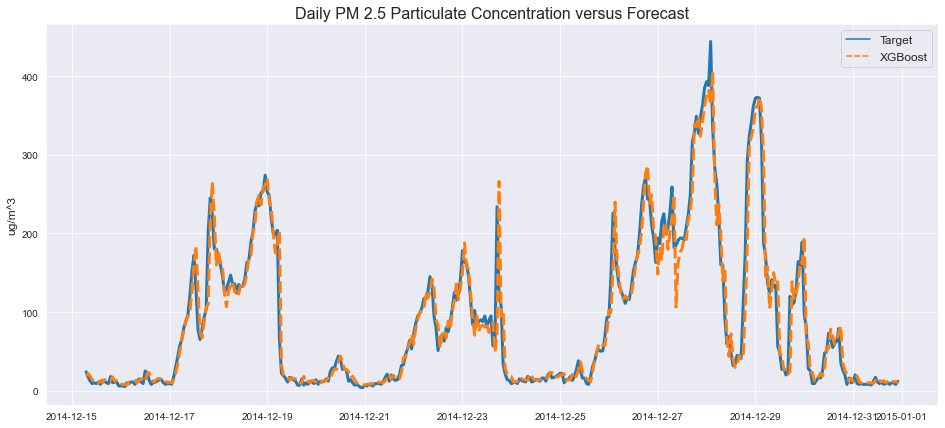

In [97]:
fig, ax = plt.subplots(figsize=(16,7))

sns.lineplot(data=df_pred[['Target', 'XGBoost']].iloc[-400:], ax=ax, linewidth=3)
plt.legend(loc='upper right', fontsize=12)
plt.title('Daily PM 2.5 Particulate Concentration versus Forecast', fontsize=16)
plt.xlabel('')
plt.ylabel('ug/m^3', fontsize=12);

### Residual Plots

In [98]:
def residual_plot(res):
    '''
    Objective: Generates four charts to assess the residuals of the model predictions -  
    a residual line chart through time; an ACF plot of residuals; a residual Q-Q plot; 
    and a kde histogram of residuals
    
    res: Residuals between the true target variable values and the model predictions
    '''
    # Standardizing residual values
    resid_standard = (res - res.mean()) / res.std()
    
    # Generate 2X2 chart plots
    figure, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 10))

    ax[0, 0].plot(res)
    ax[0, 0].axhline(res.mean(), color='grey')
    ax[0, 0].set_title('Residuals')

    plot_acf(resid_standard, title='Correlogram', ax=ax[0, 1])

    sm.graphics.qqplot(res, line='45', fit=True, ax=ax[1, 0])
    ax[1, 0].set_title('Normal Q-Q')

    x = np.linspace(res.min(), res.max(), 1000)
    norm = stats.norm(loc=0, scale=res.std())
    sns.distplot(res, ax=ax[1, 1], label='kde estimate')
    ax[1, 1].plot(x, norm.pdf(x), label='normal distribution')
    ax[1, 1].legend()
    ax[1, 1].set_title('Distribution of Residuals')

    plt.show()
    

In [99]:
residual = df_pred['Target'] - df_pred['XGBoost']

C:\Users\Micha\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


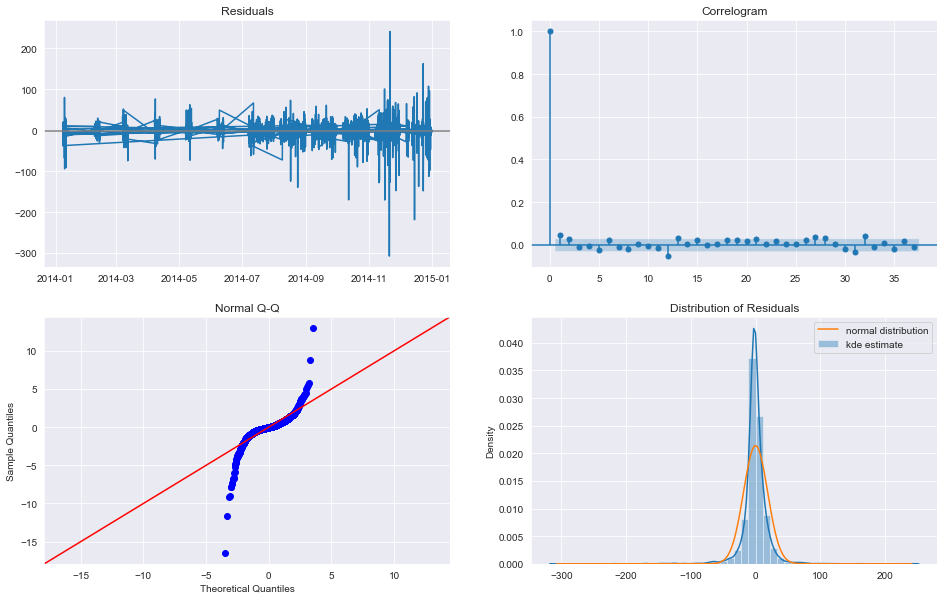

In [100]:
residual_plot(residual)